In [11]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]

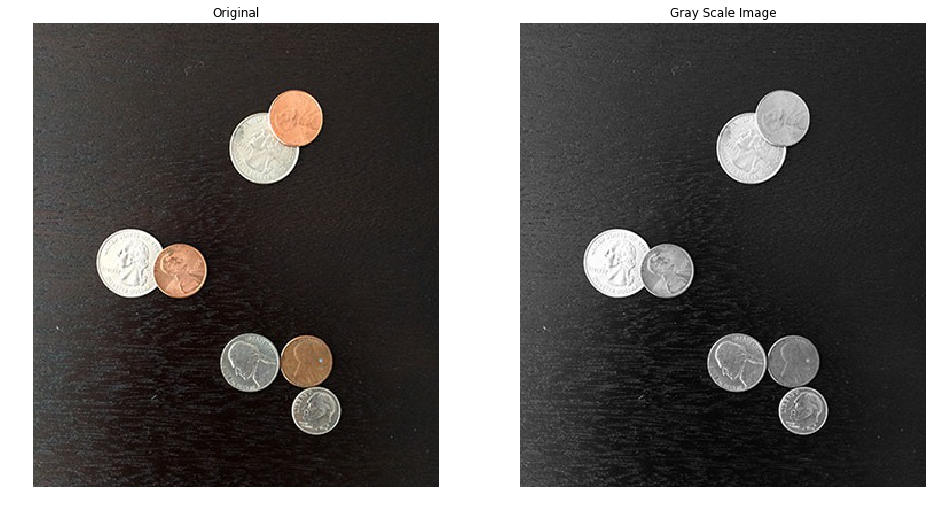

In [25]:
img=cv2.imread("watershed.jpg",cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Original")
plt.axis('off')
plt.subplot(1,2,2),plt.imshow(gray, cmap='gray'), plt.title("Gray Scale Image")
plt.axis('off')
plt.show()

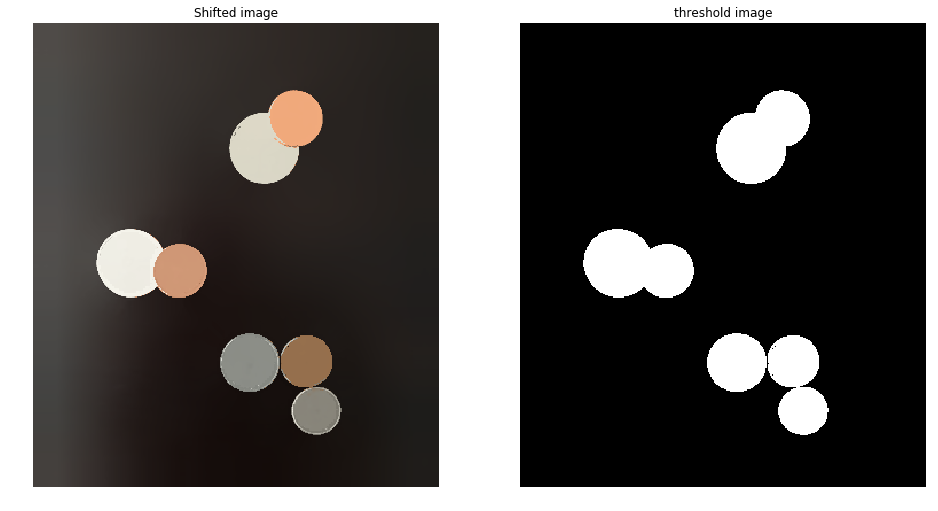

In [26]:
# load the image and perform pyramid mean shift filtering
# to aid the thresholding step
shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
 
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

plt.subplot(1,2,1),plt.imshow(cv2.cvtColor(shifted, cv2.COLOR_BGR2RGB)), plt.title("Shifted image")
plt.axis('off')
plt.subplot(1,2,2),plt.imshow(thresh, cmap='gray'), plt.title("threshold image")
plt.axis('off')
plt.show()

In [27]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=10,labels=thresh) # min_distance needs to be tuned. Was not getting result when left 20 as in tutorial.
 
# perform a connected component analysis on the local peaks
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("Number of coins found: {}".format(len(np.unique(labels)) - 1))

Number of coins found: 7


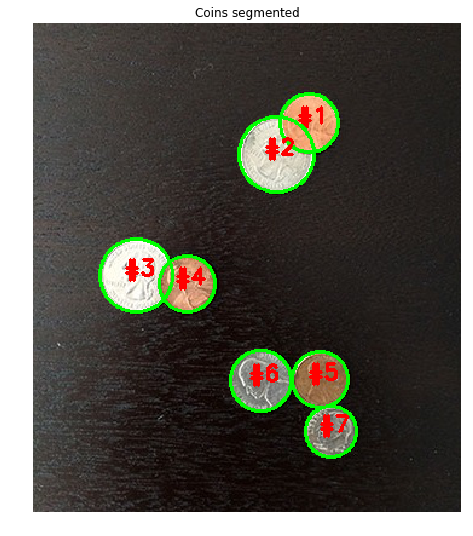

In [28]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue

    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[-2]
    c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Coins segmented")
plt.axis('off'), plt.show();

Link to tutorial: https://www.pyimagesearch.com/2015/11/02/watershed-opencv/ http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html